In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime
import seaborn as sns

import networkx as nx
import copy
import random
import getpass
import psycopg2 as ps
import os
import re
from scipy.stats import pearsonr

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
from scipy.ndimage.filters import gaussian_filter1d
from matplotlib.dates import DateFormatter, DayLocator



C:\Users\Akshay\AppData\Local\Temp\ipykernel_10452\1631993729.py:19: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [21]:
Hate_Universe = pd.read_csv('./Data/Hate_Universe.csv')

In [22]:

Jan6 = Hate_Universe[(Hate_Universe['Day'] >= '2021-01-01') & (Hate_Universe['Day']< '2021-01-11')]
Nov7 = Hate_Universe[(Hate_Universe['Day'] >= '2020-11-01') & (Hate_Universe['Day']< '2020-11-11')]


In [23]:
Jan6 = Jan6.dropna(subset=['Target'])
Nov7 = Nov7.dropna(subset= ['Target'])
# Converting to Datetime format
Jan6['Day'] = pd.to_datetime(Jan6['Day'])
Nov7['Day'] = pd.to_datetime(Nov7['Day'])
# Group by 'Day' and count the number of rows for each day
daily_counts_Jan6 = Jan6.groupby('Day').size()
daily_counts_Nov7 = Nov7.groupby('Day').size()

# Calculate the increase relative to the first day
relative_increase_Jan6 = ((daily_counts_Jan6 - daily_counts_Jan6.iloc[0])/(daily_counts_Jan6.iloc[0]))*100.00
relative_increase_Nov7 = ((daily_counts_Nov7 - daily_counts_Nov7.iloc[0])/(daily_counts_Nov7.iloc[0]))*100.00

C:\Users\Akshay\AppData\Local\Temp\ipykernel_10452\1121262663.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])  # Add '%' symbol to y-axis labels


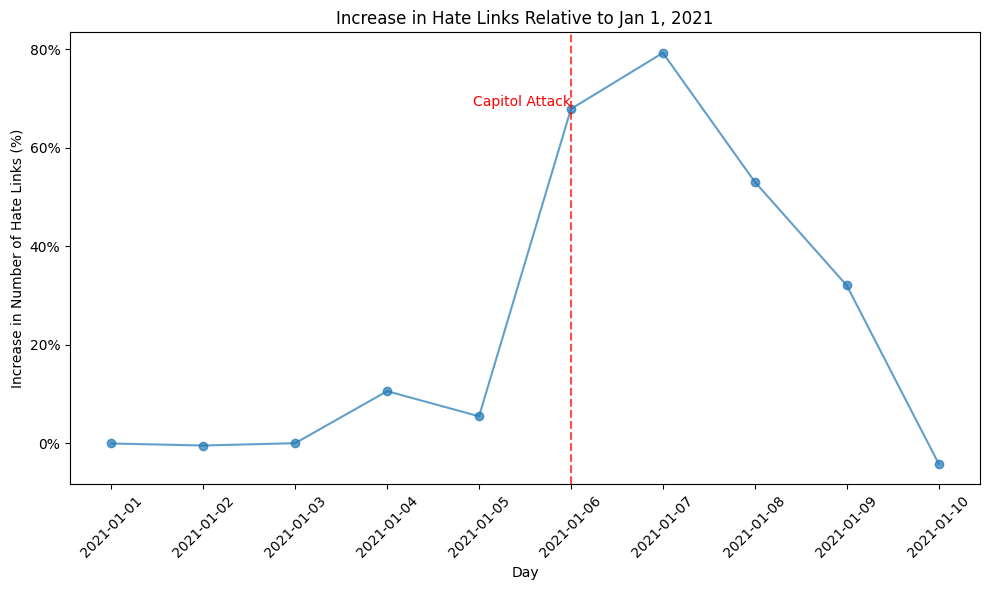

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(relative_increase_Jan6.index, relative_increase_Jan6.values, marker='o', linestyle='-', alpha=0.7, markersize=6)
plt.axvline(x=pd.Timestamp('2021-01-06'), color='red', linestyle='--', alpha=0.7)
plt.text(pd.Timestamp('2021-01-06'), relative_increase_Jan6.loc['2021-01-06'], 'Capitol Attack', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.title('Increase in Hate Links Relative to Jan 1, 2021')
plt.xlabel('Day')
plt.ylabel('Increase in Number of Hate Links (%)')
plt.xticks(rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])  # Add '%' symbol to y-axis labels
plt.tight_layout()
plt.grid(False)  # Removing gridlines

C:\Users\Akshay\AppData\Local\Temp\ipykernel_10452\4186470596.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])  # Add '%' symbol to y-axis labels


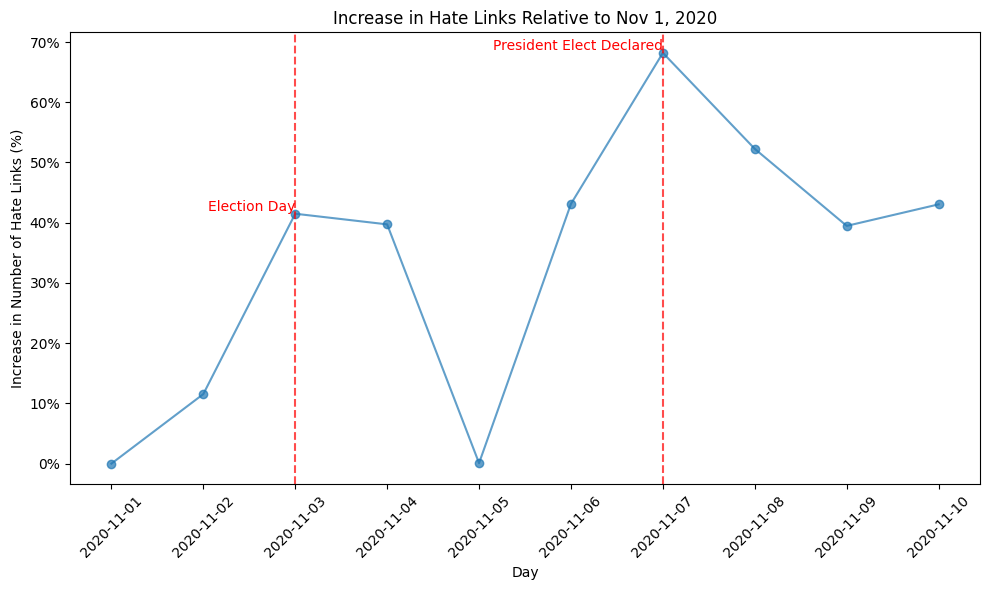

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(relative_increase_Nov7.index, relative_increase_Nov7.values, marker='o', linestyle='-', alpha=0.7, markersize=6)
plt.axvline(x=pd.Timestamp('2020-11-03'), color='red', linestyle='--', alpha=0.7)

plt.axvline(x=pd.Timestamp('2020-11-07'), color='red', linestyle='--', alpha=0.7)
plt.text(pd.Timestamp('2020-11-03'), relative_increase_Nov7.loc['2020-11-03'], 'Election Day', color='red', verticalalignment='bottom', horizontalalignment='right')

plt.text(pd.Timestamp('2020-11-07'), relative_increase_Nov7.loc['2020-11-07'], 'President Elect Declared', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.title('Increase in Hate Links Relative to Nov 1, 2020')
plt.xlabel('Day')
plt.ylabel('Increase in Number of Hate Links (%)')
plt.xticks(rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])  # Add '%' symbol to y-axis labels
plt.tight_layout()
plt.grid(False)  # Removing gridlines
plt.show()

In [26]:

pre_election = Hate_Universe[(Hate_Universe['Day'] >= '2020-11-01') & (Hate_Universe['Day']< '2020-11-03')]

post_election = Hate_Universe[(Hate_Universe['Day'] >=  '2020-11-03') & (Hate_Universe['Day']< '2020-11-05')]


pre_Jan6 = Hate_Universe[(Hate_Universe['Day'] >= '2021-01-01') & (Hate_Universe['Day'] < '2021-01-06')]


post_Jan6 = Hate_Universe[(Hate_Universe['Day']  >= '2021-01-06') & (Hate_Universe['Day'] < '2021-01-11')]


In [27]:
pre_election = pre_election.dropna(subset=['Target'])
post_election = post_election.dropna(subset= ['Target'])
pre_Jan6 = pre_Jan6.dropna(subset=['Target'])
post_Jan6 = post_Jan6.dropna(subset= ['Target'])

In [28]:
Graph_pre_Nov7= nx.from_pandas_edgelist(pre_election, 'Source', 'Target',  create_using=nx.Graph())
Graph_post_Nov7 = nx.from_pandas_edgelist(post_election, 'Source', 'Target',  create_using=nx.Graph())

In [29]:

def calculate_percentage_change(pre, post):
    return ((post - pre) / pre) * 100

# Calculate properties for Graph_pre_Jan6
pre_density = nx.density(Graph_pre_Nov7)
pre_cliques = list(nx.find_cliques(Graph_pre_Nov7))
pre_max_clique_size = max(len(clique) for clique in pre_cliques)
pre_num_communities = nx.number_connected_components(Graph_pre_Nov7)
pre_largest_community = max(len(c) for c in nx.connected_components(Graph_pre_Nov7))
pre_clustering_coefficient = nx.average_clustering(Graph_pre_Nov7)
pre_assortativity = nx.assortativity.degree_assortativity_coefficient(Graph_pre_Nov7)

# Calculate properties for Graph_post_Jan6
post_density = nx.density(Graph_post_Nov7)
post_cliques = list(nx.find_cliques(Graph_post_Nov7))
post_max_clique_size = max(len(clique) for clique in post_cliques)
post_num_communities = nx.number_connected_components(Graph_post_Nov7)
post_largest_community = max(len(c) for c in nx.connected_components(Graph_post_Nov7))
post_clustering_coefficient = nx.average_clustering(Graph_post_Nov7)
post_assortativity = nx.assortativity.degree_assortativity_coefficient(Graph_post_Nov7)

In [30]:
data = {
    'Property': ['Density', 'Number of Cliques', 'Max Clique Size', 'Number of Communities',
                 'Size of Largest Community', 'Clustering Coefficient', 'Assortativity'],
    'Pre_election': [pre_density, len(pre_cliques), pre_max_clique_size, pre_num_communities,
                 pre_largest_community, pre_clustering_coefficient, pre_assortativity],
    'Post_election': [post_density, len(post_cliques), post_max_clique_size, post_num_communities,
                  post_largest_community, post_clustering_coefficient, post_assortativity]
}

df = pd.DataFrame(data)

for prop in data['Property']:
    pre_value = df.loc[df['Property'] == prop, 'Pre_election'].values[0]
    post_value = df.loc[df['Property'] == prop, 'Post_election'].values[0]
    percentage_change = calculate_percentage_change(pre_value, post_value)
    df.loc[df['Property'] == prop, 'Percentage Change'] = percentage_change


# Display the DataFrame
print(df)

                    Property  Pre_election  Post_election  Percentage Change
0                    Density      0.000490       0.000472          -3.565110
1          Number of Cliques   4848.000000    5451.000000          12.438119
2            Max Clique Size      4.000000       5.000000          25.000000
3      Number of Communities     69.000000      66.000000          -4.347826
4  Size of Largest Community   4338.000000    4741.000000           9.289995
5     Clustering Coefficient      0.012406       0.013942          12.374499
6              Assortativity     -0.517206      -0.489788          -5.301101


In [31]:
Graph_pre_Jan6 = nx.from_pandas_edgelist(pre_Jan6, 'Source', 'Target',  create_using=nx.Graph())
Graph_post_Jan6 = nx.from_pandas_edgelist(post_Jan6, 'Source', 'Target',  create_using=nx.Graph())

In [32]:
# Calculate properties for Graph_pre_Jan6
pre_density = nx.density(Graph_pre_Jan6)
pre_cliques = list(nx.find_cliques(Graph_pre_Jan6))
pre_max_clique_size = max(len(clique) for clique in pre_cliques)
pre_num_communities = nx.number_connected_components(Graph_pre_Jan6)
pre_largest_community = max(len(c) for c in nx.connected_components(Graph_pre_Jan6))
pre_clustering_coefficient = nx.average_clustering(Graph_pre_Jan6)
pre_assortativity = nx.assortativity.degree_assortativity_coefficient(Graph_pre_Jan6)

# Calculate properties for Graph_post_Jan6
post_density = nx.density(Graph_post_Jan6)
post_cliques = list(nx.find_cliques(Graph_post_Jan6))
post_max_clique_size = max(len(clique) for clique in post_cliques)
post_num_communities = nx.number_connected_components(Graph_post_Jan6)
post_largest_community = max(len(c) for c in nx.connected_components(Graph_post_Jan6))
post_clustering_coefficient = nx.average_clustering(Graph_post_Jan6)
post_assortativity = nx.assortativity.degree_assortativity_coefficient(Graph_post_Jan6)


In [33]:
data = {
    'Property': ['Density', 'Number of Cliques', 'Max Clique Size', 'Number of Communities',
                 'Size of Largest Community', 'Clustering Coefficient', 'Assortativity'],
    'Pre_Jan6': [pre_density, len(pre_cliques), pre_max_clique_size, pre_num_communities,
                 pre_largest_community, pre_clustering_coefficient, pre_assortativity],
    'Post_Jan6': [post_density, len(post_cliques), post_max_clique_size, post_num_communities,
                  post_largest_community, post_clustering_coefficient, post_assortativity]
}

df = pd.DataFrame(data)

for prop in data['Property']:
    pre_value = df.loc[df['Property'] == prop, 'Pre_Jan6'].values[0]
    post_value = df.loc[df['Property'] == prop, 'Post_Jan6'].values[0]
    percentage_change = calculate_percentage_change(pre_value, post_value)
    df.loc[df['Property'] == prop, 'Percentage Change'] = percentage_change


# Display the DataFrame
print(df)

                    Property     Pre_Jan6    Post_Jan6  Percentage Change
0                    Density     0.000313     0.000312          -0.109361
1          Number of Cliques  7835.000000  9839.000000          25.577537
2            Max Clique Size     5.000000     5.000000           0.000000
3      Number of Communities   110.000000    89.000000         -19.090909
4  Size of Largest Community  6892.000000  8028.000000          16.482879
5     Clustering Coefficient     0.012156     0.032198         164.878865
6              Assortativity    -0.493561    -0.359890         -27.082979



## Hate Type

In [34]:
df_Nov7 = pd.read_csv('./Data/df_Nov7_hate_type.csv')
df_jan6 = pd.read_csv('./Data/df_jan6_hate_type.csv')

In [35]:
Pre_jan6 = df_jan6[(df_jan6['Day'] >= '2021-01-01') & (df_jan6['Day'] <= '2021-01-05')]
Post_jan6 = df_jan6[(df_jan6['Day'] >= '2021-01-06') & (df_jan6['Day'] <= '2021-01-10')]
Pre_Nov7 = df_Nov7[(df_Nov7['Day'] >= '2020-11-02') & (df_Nov7['Day'] <= '2020-11-06')]
Post_Nov7 = df_Nov7[(df_Nov7['Day'] >= '2020-11-07') & (df_Nov7['Day'] <= '2020-11-11')]

In [36]:
boolean_columns = ['religion_prediction', 'race_prediction', 'gender_prediction',
                   'giso_prediction', 'immigration_prediction', 'ein_prediction', 
                   'antisemitism_prediction', 'SNS Source']

# Group by 'SNS' column and sum the boolean columns
hate_counts_pre = Pre_jan6[boolean_columns].groupby('SNS Source').sum()

# Group by 'SNS' column and sum the boolean columns
hate_counts_post = Post_jan6[boolean_columns].groupby('SNS Source').sum()

# Display the counts of hate types for each SNS
hate_counts_post

,religion_prediction,race_prediction,gender_prediction,giso_prediction,immigration_prediction,ein_prediction,antisemitism_prediction
SNS Source,,,,,,,
4Chan,263,610,52,553,25,274,703
Bitchute,13,33,1,15,2,10,52
FB,1,0,0,0,0,0,0
Gab,7,6,6,0,3,1,13
Rumble,0,4,0,0,0,3,1
TG,16,45,1,7,14,53,30
Twitter,0,49,2,4,5,1,12
VK,0,0,0,0,0,0,0
YouTube,17,0,0,1,0,0,1


In [37]:
percentage_change = ((hate_counts_post - hate_counts_pre) / (hate_counts_pre+1)) * 100
percentage_change

,religion_prediction,race_prediction,gender_prediction,giso_prediction,immigration_prediction,ein_prediction,antisemitism_prediction
SNS Source,,,,,,,
4Chan,78.378378,-9.615385,-14.516129,67.371601,73.333333,-26.470588,4.918033
Bitchute,-64.102564,-33.333333,-33.333333,14.285714,50.0,-57.692308,-49.038462
FB,100.0,0.0,0.0,0.0,0.0,0.0,0.0
Gab,33.333333,0.0,250.0,-66.666667,100.0,-60.0,133.333333
Rumble,0.0,400.0,0.0,0.0,0.0,-20.0,0.0
TG,112.5,-4.166667,0.0,14.285714,650.0,25.581395,-24.390244
Twitter,-50.0,-35.897436,-62.5,25.0,-14.285714,-75.0,30.0
VK,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YouTube,-74.285714,-66.666667,0.0,100.0,0.0,0.0,100.0


In [38]:
total_pre = hate_counts_pre.sum()
total_post = hate_counts_post.sum()

# Calculate the percentage change without considering the SNS
percentage_change_total = ((total_post - total_pre) / total_pre) * 100

# Display the percentage change
print(percentage_change_total)

religion_prediction         18.726592
race_prediction            -12.835473
gender_prediction          -13.888889
giso_prediction             63.841808
immigration_prediction     113.043478
ein_prediction             -24.835165
antisemitism_prediction     -1.932367
dtype: object


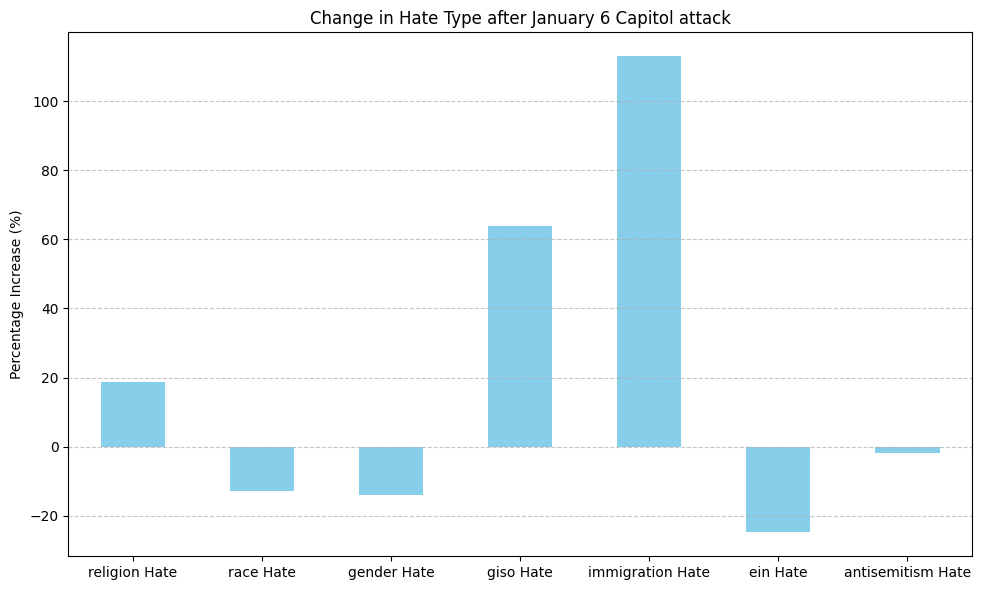

In [39]:
# Remove "prediction" and replace it with "hate" in the x-axis labels
x_labels = [label.replace('_prediction', ' Hate') for label in percentage_change_total.index]
# Plotting the percentage change
# Plotting the percentage change
plt.figure(figsize=(10, 6))
percentage_change_total.plot(kind='bar', color='skyblue')
plt.title('Change in Hate Type after January 6 Capitol attack')
plt.ylabel('Percentage Increase (%)')
plt.xticks(range(len(x_labels)), x_labels, rotation=0, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [40]:
boolean_columns = ['religion_prediction', 'race_prediction', 'gender_prediction',
                   'giso_prediction', 'immigration_prediction', 'ein_prediction', 
                   'antisemitism_prediction', 'SNS Source']

# Group by 'SNS' column and sum the boolean columns
hate_counts_pre = Pre_Nov7[boolean_columns].groupby('SNS Source').sum()

# Group by 'SNS' column and sum the boolean columns
hate_counts_post = Post_Nov7[boolean_columns].groupby('SNS Source').sum()


In [41]:
percentage_change = ((hate_counts_post - hate_counts_pre) / (hate_counts_pre +1) ) * 100
percentage_change

,religion_prediction,race_prediction,gender_prediction,giso_prediction,immigration_prediction,ein_prediction,antisemitism_prediction
SNS Source,,,,,,,
4Chan,21.698113,51.48368,3.333333,14.690265,925.0,132.831325,142.561983
Bitchute,-66.666667,36.842105,200.0,500.0,0.0,7.142857,72.727273
FB,0.0,0.0,0.0,0.0,-50.0,0.0,0.0
Gab,-47.368421,0.0,-50.0,600.0,33.333333,-40.0,23.076923
Instagram,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rumble,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TG,-28.571429,-31.578947,-50.0,300.0,0.0,-68.181818,-52.631579
Twitter,14.285714,-45.555556,100.0,-54.545455,-82.142857,-11.111111,262.5
VK,0.0,0.0,0.0,-50.0,0.0,0.0,100.0


In [42]:
total_pre = hate_counts_pre.sum()
total_post = hate_counts_post.sum()

# Calculate the percentage change without considering the SNS
percentage_change_total = ((total_post - total_pre) / total_pre) * 100

# Display the percentage change
print(percentage_change_total)

religion_prediction          7.142857
race_prediction             35.023585
gender_prediction           -0.961538
giso_prediction             18.181818
immigration_prediction     269.565217
ein_prediction              98.536585
antisemitism_prediction    117.520661
dtype: object


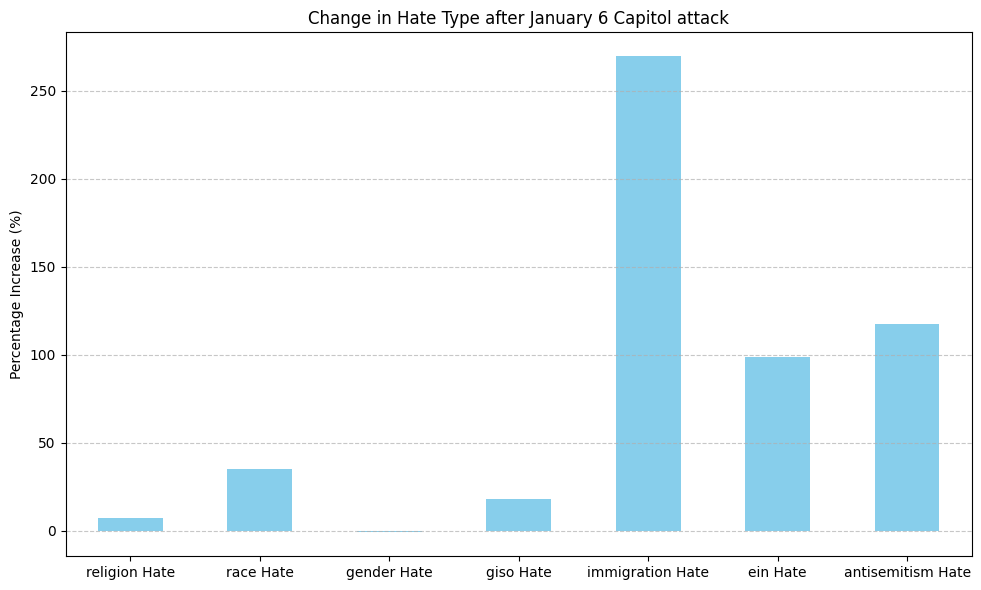

In [43]:
# Remove "prediction" and replace it with "hate" in the x-axis labels
x_labels = [label.replace('_prediction', ' Hate') for label in percentage_change_total.index]
# Plotting the percentage change
# Plotting the percentage change
plt.figure(figsize=(10, 6))
percentage_change_total.plot(kind='bar', color='skyblue')
plt.title('Change in Hate Type after January 6 Capitol attack')
plt.ylabel('Percentage Increase (%)')
plt.xticks(range(len(x_labels)), x_labels, rotation=0, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Correlation 


In [44]:
Hate_Universe = pd.read_csv('./Data/Hate_Universe.csv')
Daily_count_flavors_df = pd.read_csv('./Data/Daily_count_flavors_df.csv', index_col='Day')

In [45]:

SNS_columns  = Hate_Universe['SNS Source'].unique().tolist()
print(SNS_columns)
Daily_count_sns_df = pd.DataFrame()

for column in SNS_columns:

    true_counts = Hate_Universe[Hate_Universe['SNS Source'] == column].groupby('Day').size()
    Daily_count_sns_df[column] = true_counts
    



['4Chan', 'Gab', 'FB', 'TG', 'Twitter', 'Rumble', 'YouTube', 'Bitchute', 'VK', 'Instagram']


In [46]:

correlations = {}
for col1 in Daily_count_flavors_df.columns:
    for col2 in Daily_count_sns_df.columns:
        correlation = Daily_count_flavors_df[col1].corr(Daily_count_sns_df[col2])
        correlations[(col1, col2)] = correlation

for pair, correlation in correlations.items():
    print(f"Correlation between {pair[0]} and {pair[1]}: {correlation}")

Correlation between Religion hate and 4Chan: 0.1740571119377957
Correlation between Religion hate and Gab: 0.09232032029928845
Correlation between Religion hate and FB: 0.07886376142854232
Correlation between Religion hate and TG: -0.11816963816727309
Correlation between Religion hate and Twitter: -0.09343070511069951
Correlation between Religion hate and Rumble: 0.017811586305907633
Correlation between Religion hate and YouTube: -0.1468514104136564
Correlation between Religion hate and Bitchute: -0.1055601925507171
Correlation between Religion hate and VK: -0.1652308691751868
Correlation between Religion hate and Instagram: nan
Correlation between Race hate and 4Chan: 0.7400919458380585
Correlation between Race hate and Gab: 0.6535706815040433
Correlation between Race hate and FB: 0.2995062757871462
Correlation between Race hate and TG: 0.674462467726148
Correlation between Race hate and Twitter: 0.7700775946566821
Correlation between Race hate and Rumble: -0.01615050864483273
Correla

c:\Users\Akshay\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Akshay\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Akshay\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Akshay\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Akshay\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Akshay\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\functi

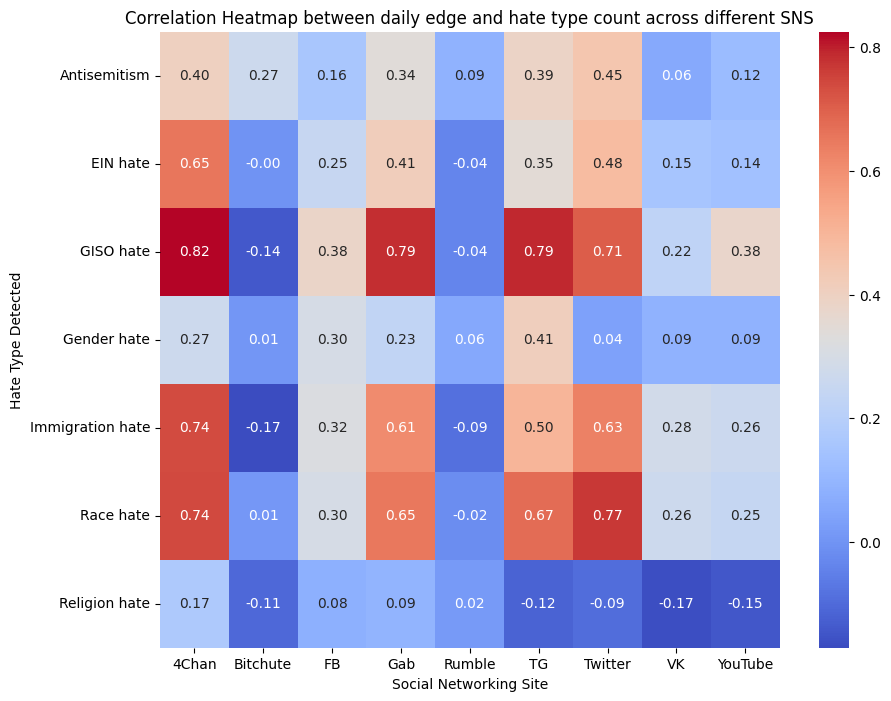

In [47]:
columns1, columns2 = zip(*correlations.keys())

# Extract correlation values
correlation_values = list(correlations.values())

# Create a DataFrame from the correlation values with columns as the original column names
correlation_df = pd.DataFrame({'Column1': columns1, 'Column2': columns2, 'Correlation': correlation_values})

# Pivot the DataFrame to create a correlation matrix
correlation_matrix = correlation_df.pivot(index='Column1', columns='Column2', values='Correlation')

# Remove the 'Instagram' column and row from the correlation matrix

correlation_matrix = correlation_matrix.drop('Instagram', axis=1)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between daily edge and hate type count across different SNS')
plt.xlabel('Social Networking Site')
plt.ylabel('Hate Type Detected')
plt.show()

## Telegram

In [48]:
SNS_Hate_Core = pd.read_csv("./Data/SNS_Hate_Core.csv")

In [49]:

pre_election_sns = SNS_Hate_Core[(SNS_Hate_Core['Day'] >= '2020-11-01') & (SNS_Hate_Core['Day']<= '2020-11-03')]

post_election_sns = SNS_Hate_Core[(SNS_Hate_Core['Day'] >  '2020-11-03') & (SNS_Hate_Core['Day']<= '2020-11-07')]


In [50]:
Graph_pre_election= nx.from_pandas_edgelist(pre_election_sns, 'SNS Source', 'SNS Target',  create_using=nx.MultiDiGraph())
Graph_post_election = nx.from_pandas_edgelist(post_election_sns, 'SNS Source', 'SNS Target',  create_using=nx.MultiDiGraph())

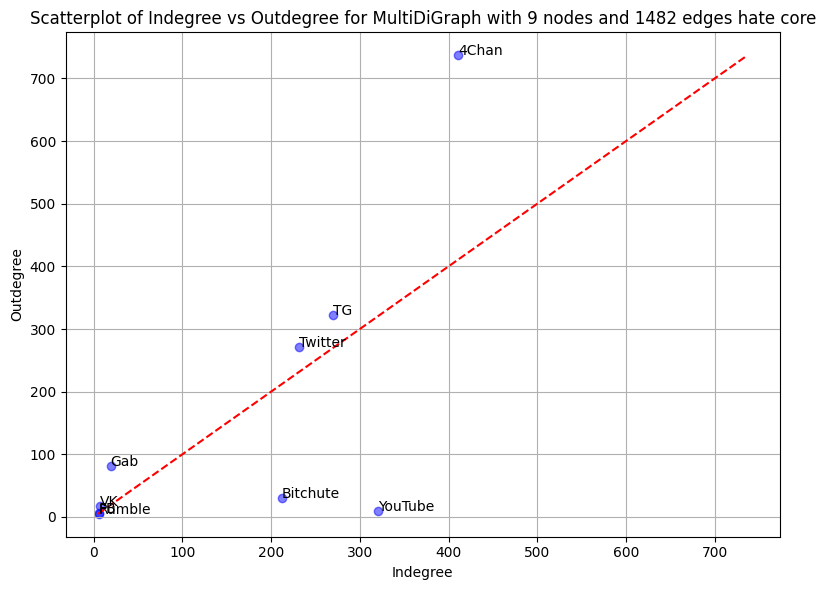

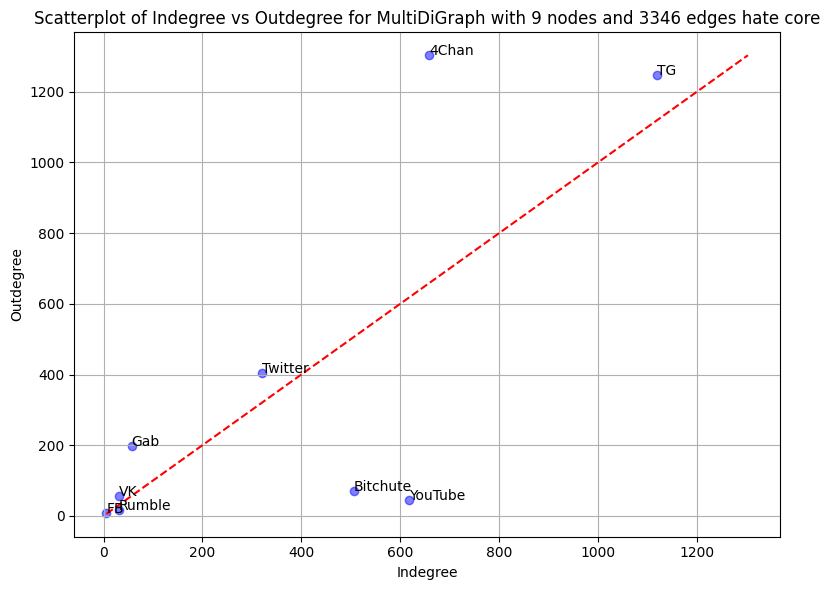

In [51]:

for graph in [Graph_pre_election, Graph_post_election]:
    indegree_dict = dict(graph.in_degree())
    outdegree_dict = dict(graph.out_degree())


    indegree_values = list(indegree_dict.values())
    outdegree_values = list(outdegree_dict.values())
    node_names = list(graph.nodes())


    plt.figure(figsize=(8, 6))
    plt.scatter(indegree_values, outdegree_values, color='blue', alpha=0.5)
    plt.xlabel('Indegree')
    plt.ylabel('Outdegree')
    plt.title(f'Scatterplot of Indegree vs Outdegree for {graph} hate core')
    plt.grid(True)

    for i, name in enumerate(node_names):
        plt.annotate(name, (indegree_values[i], outdegree_values[i]))


    # Determine the range for the diagonal line
    max_value = max(max(indegree_values), max(outdegree_values))
    min_value = min(min(indegree_values), min(outdegree_values))

    # Plot diagonal line
    plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

In [52]:
degree_pre_election = Graph_pre_election.degree('TG')
degree_post_election = Graph_post_election.degree('TG')

# 2. Calculate the increase in degree
increase_in_degree = ((degree_post_election - degree_pre_election)/degree_pre_election)*100

print("Increase in degree of node 'TG':", increase_in_degree)

Increase in degree of node 'TG': 299.66216216216213


In [53]:
total_in_links_pre_election = sum(dict(Graph_pre_election.in_degree()).values())
total_out_links_pre_election = sum(dict(Graph_pre_election.out_degree()).values())

total_in_links_post_election = sum(dict(Graph_post_election.in_degree()).values())
total_out_links_post_election = sum(dict(Graph_post_election.out_degree()).values())

# Calculate the in-degree and out-degree of node "TG" for both graphs
in_degree_pre_election_TG = Graph_pre_election.in_degree('TG')
out_degree_pre_election_TG = Graph_pre_election.out_degree('TG')

in_degree_post_election_TG = Graph_post_election.in_degree('TG')
out_degree_post_election_TG = Graph_post_election.out_degree('TG')

# Calculate the percentages
percent_in_links_pre_election = (in_degree_pre_election_TG / total_in_links_pre_election) * 100
percent_out_links_pre_election = (out_degree_pre_election_TG / total_out_links_pre_election) * 100

percent_in_links_post_election = (in_degree_post_election_TG / total_in_links_post_election) * 100
percent_out_links_post_election = (out_degree_post_election_TG / total_out_links_post_election) * 100

print("Percentage of in-links of node 'TG' in Graph_pre_election:", percent_in_links_pre_election)
print("Percentage of out-links of node 'TG' in Graph_pre_election:", percent_out_links_pre_election)

print("Percentage of in-links of node 'TG' in Graph_post_election:", percent_in_links_post_election)
print("Percentage of out-links of node 'TG' in Graph_post_election:", percent_out_links_post_election)

Percentage of in-links of node 'TG' in Graph_pre_election: 18.218623481781375
Percentage of out-links of node 'TG' in Graph_pre_election: 21.727395411605936
Percentage of in-links of node 'TG' in Graph_post_election: 33.47280334728033
Percentage of out-links of node 'TG' in Graph_post_election: 37.238493723849366


In [54]:
print(pd.__version__)

2.2.2
